<center>
    <h1><b>PCA - Heart Disease Prediction</b></h1>
</center>

### Problem

Download the heart disease dataset heart.csv and do the following:

 1. Load heart disease dataset in pandas dataframe.
 2. Remove outliers using Z-score. Usual guideline is to remove anything that has Z-score > 3 formula or Z-score <-3
 3. Covert text columns to numbers using label encoding and one hot encoding
 4. Apply scaling
 5. Build a classification model using methods(SVM, logistic regression, random forest) and check which model gives the best accuracy
 6. Now use PCA to reduce dimensions, retrain the model and see what impact it has on the model in terms of accuracy. keep in mind that many times doing PCA reduces the accuracy but computation is much lighter and that's the trade off needed to consider while building models in real life

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
import pickle as pk

%matplotlib inline

### Loading the Dataset

In [2]:
df = pd.read_csv(r'D:\AI Engineering\Python\My_Projects\Datasets\heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Data Exploration

In [3]:
df.shape

(918, 12)

In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
# columns with numeric values
num_cols = [col for col in df.select_dtypes(exclude = 'object').columns]

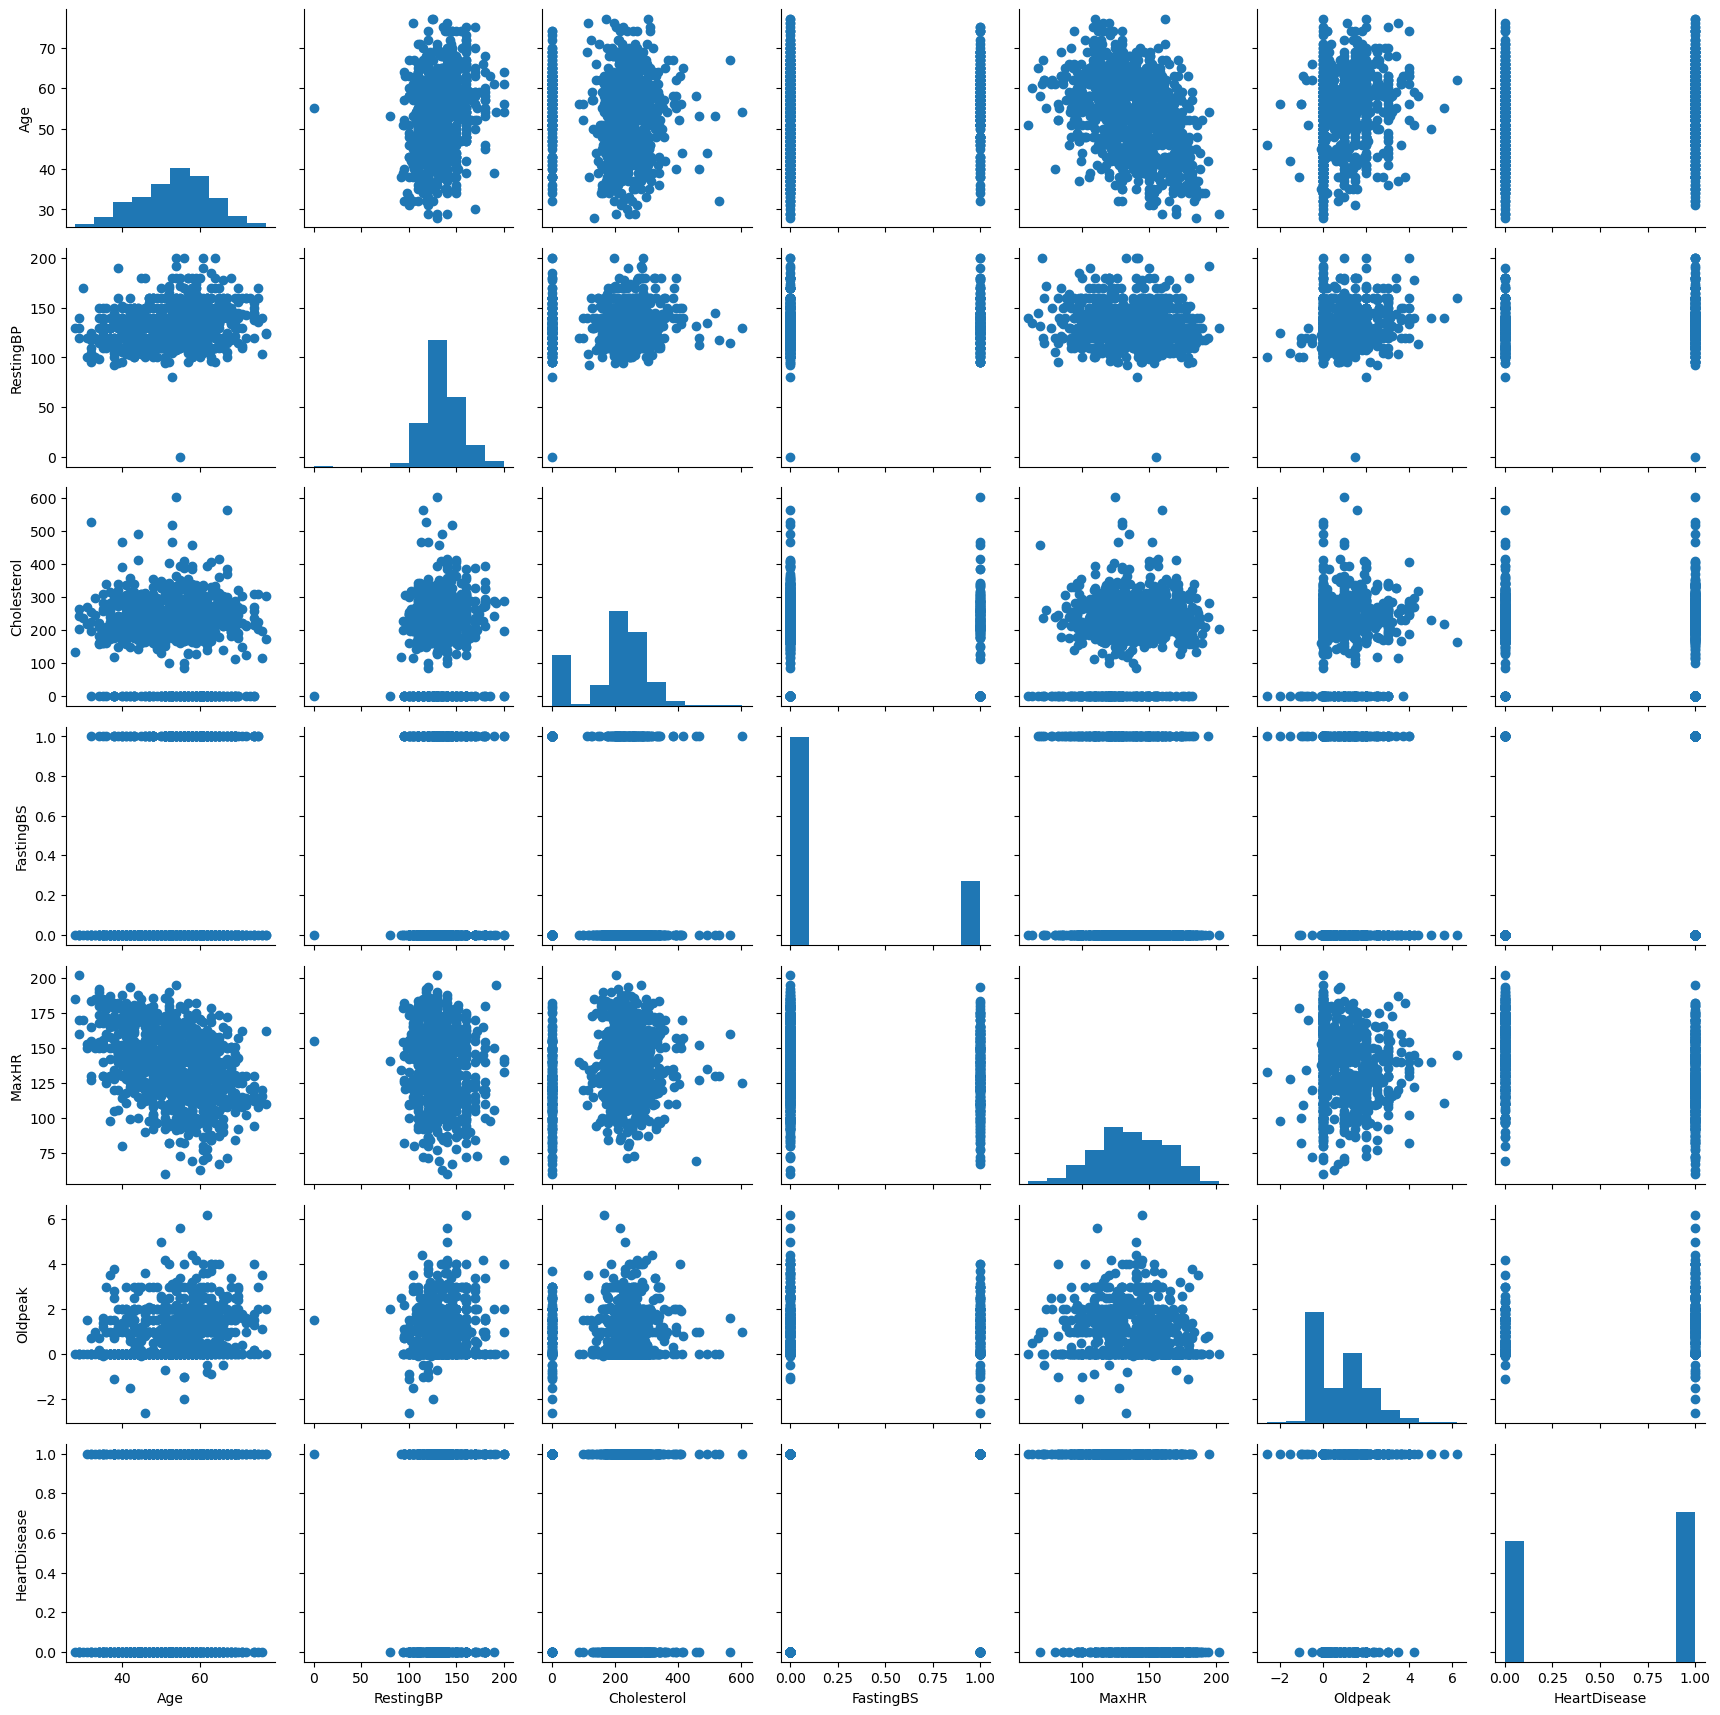

In [8]:
# Pairwise Visualization
pairwise = sb.PairGrid(data = df, vars = num_cols)
pairwise = pairwise.map_diag(plt.hist, bins = 10)
pairwise.map_offdiag(plt.scatter);

In [9]:
# List of columns
df.columns.tolist()

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

In [10]:
cols = ['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'HeartDisease']

C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

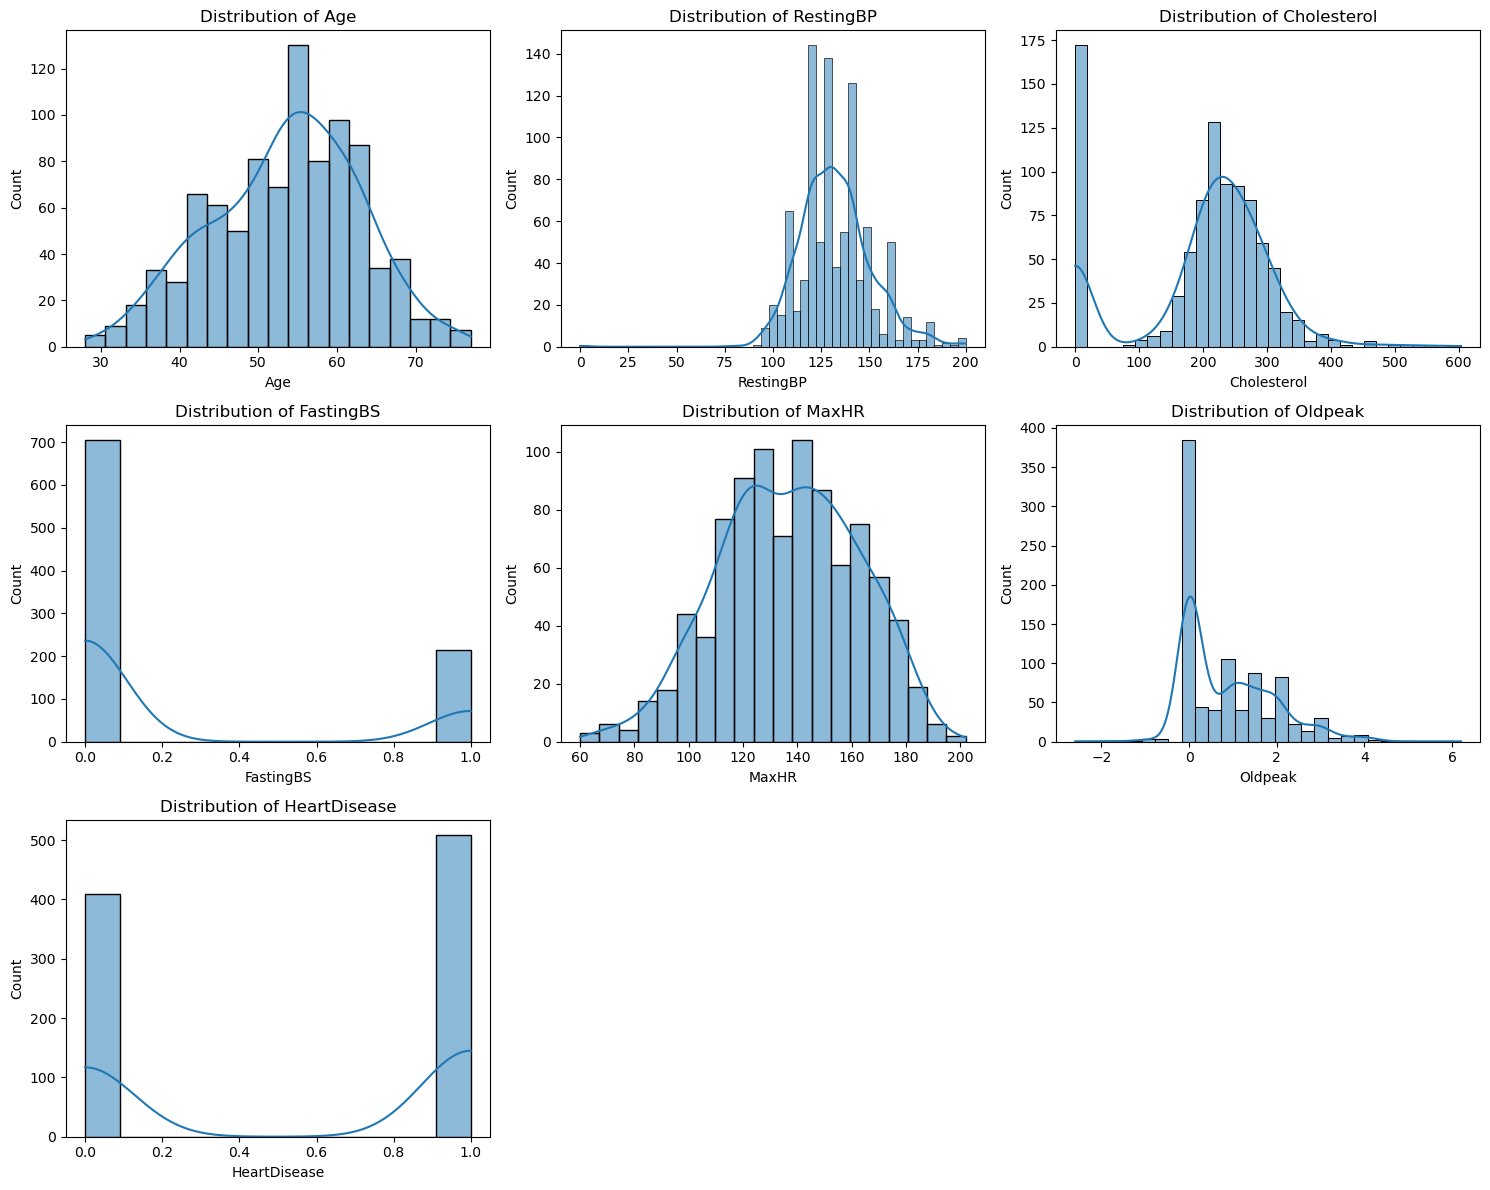

In [11]:
# Set the size of the plots
plt.figure(figsize=(15, 12))

# Loop through each column and create a histogram with KDE
for i, column in enumerate(df[cols], 1):
    plt.subplot(3, 3, i) 
    sb.histplot(df[column], kde=True)  # Plotting histogram with KDE
    plt.title(f'Distribution of {column}')  # title for each subplot

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


### Using z-score to find and remove outliers from some columns

From the visualization above, it can be deduced that ``'RestingBP'``, ``'Cholestol'``, and ``'OldPeak'`` columns are not distributed normally due to outliers

#### RestingBP column

In [12]:
# 'RestingBP' mean and standard deviation
_, mean, std, *_ = df['RestingBP'].describe()
mean, std

(132.39651416122004, 18.514154119907808)

In [13]:
def get_z_score(value, mean, std):
    return (value - mean) / std

In [14]:
# creating a new column RestingBP_zscore to store RestingBP zscore values
df['RestingBP_zscore'] = df['RestingBP'].apply(lambda x: get_z_score(x, mean, std))
df.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0.410685
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,1.490940


In [15]:
# Viewing outlier values in RestingBP column
df[(df['RestingBP_zscore'] < -3) | (df['RestingBP_zscore'] > 3)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore
109,39,M,ATA,190,241,0,Normal,106,N,0.0,Up,0,3.111322
241,54,M,ASY,200,198,0,Normal,142,Y,2.0,Flat,1,3.651449
365,64,F,ASY,200,0,0,Normal,140,Y,1.0,Flat,1,3.651449
399,61,M,NAP,200,0,1,ST,70,N,0.0,Flat,1,3.651449
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1,-7.151097
592,61,M,ASY,190,287,1,LVH,150,Y,2.0,Down,1,3.111322
732,56,F,ASY,200,288,1,LVH,133,Y,4.0,Down,1,3.651449
759,54,M,ATA,192,283,0,LVH,195,N,0.0,Up,1,3.219347


In [16]:
# examining the remaining dataset after removing outliers in RestingBP_z
df_restBP = df[(df['RestingBP_zscore'] > -3) & (df['RestingBP_zscore'] < 3)]
df_restBP.shape

(910, 13)

C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


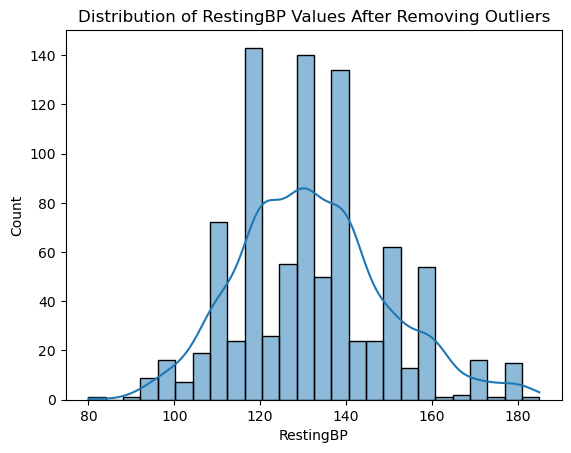

In [17]:
# Visualizing the distribution after removing outliers
sb.histplot(df_restBP['RestingBP'], kde=True)
plt.title('Distribution of RestingBP Values After Removing Outliers')
plt.show();

#### Cholesterol column

In [18]:
# creating a new column RestingBP_zscore to store RestingBP zscore values
df_restBP.loc[:, 'Cholesterol_zscore'] = df_restBP.loc[:, 'Cholesterol'].apply(lambda x: get_z_score(x, mean, std))
df_restBP.head(2)

C:\Users\Banji\AppData\Local\Temp\ipykernel_1076\1157573155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restBP.loc[:, 'Cholesterol_zscore'] = df_restBP.loc[:, 'Cholesterol'].apply(lambda x: get_z_score(x, mean, std))


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore,Cholesterol_zscore
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0.410685,8.458582
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,1.490940,2.571194


In [19]:
df_restBP[(df_restBP['Cholesterol_zscore'] < -3) | (df_restBP['Cholesterol_zscore'] > 3)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore,Cholesterol_zscore
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0.410685,8.458582
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,-0.129442,8.134505
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0.302660,4.407627
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,0.950812,3.381385
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0,-0.669570,11.159218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,63,F,ASY,124,197,0,Normal,136,Y,0.0,Flat,1,-0.453519,3.489411
912,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1,0.410685,5.865971
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1,-1.209697,7.108263
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1,0.626736,3.273360


#### Another method will be used to remove the outliers in Cholesterol instead of zscore. any value that is <= 0 or > 1000 will be removed 

In [20]:
df_restBP[(df_restBP['Cholesterol'] <= 0) | (df_restBP['Cholesterol'] > 450)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore,Cholesterol_zscore
28,53,F,ATA,113,468,0,Normal,127,N,0.0,Up,0,-1.047659,18.126860
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1,0.680749,20.827497
76,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1,-0.777595,21.421637
103,40,M,ASY,120,466,1,Normal,152,Y,1.0,Flat,1,-0.669570,18.018835
149,54,M,ASY,130,603,1,Normal,125,Y,1.0,Flat,1,-0.129442,25.418579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0,-0.129442,-7.151097
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1,-1.641799,-7.151097
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1,-0.129442,-7.151097
536,62,M,NAP,133,0,1,ST,119,Y,1.2,Flat,1,0.032596,-7.151097


In [21]:
# examining the remaining dataset after removing outliers in RestingBP_z
df_chol = df_restBP[(df_restBP['Cholesterol'] > 0) & (df_restBP['Cholesterol']  <= 450)]
df_chol.shape

(733, 14)

C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


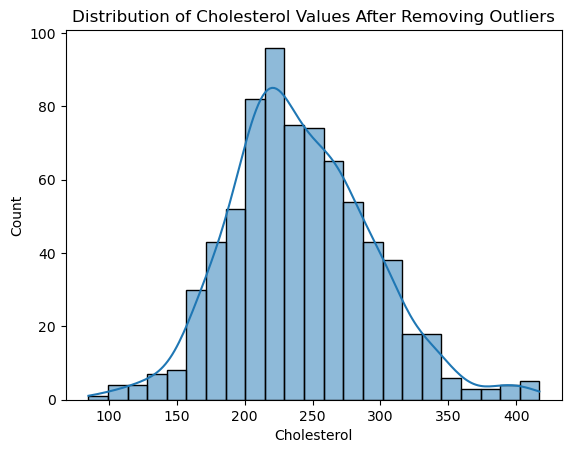

In [22]:
# Visualizing the distribution after removing outliers
sb.histplot(df_chol['Cholesterol'], kde=True)
plt.title('Distribution of Cholesterol Values After Removing Outliers')
plt.show();

#### Oldpeak column Outlier Removal Using Quantile

In [23]:
lower_qrt = df_chol['Oldpeak'].quantile(.002)
lower_qrt

0.0

In [24]:
higher_qrt = df_chol['Oldpeak'].quantile(.99)
higher_qrt

4.0

In [25]:
# Viewing rows with outliers
df_chol[(df_chol['Oldpeak'] < lower_qrt) | (df_chol['Oldpeak'] > higher_qrt)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore,Cholesterol_zscore
166,50,M,ASY,140,231,0,ST,140,Y,5.0,Flat,1,0.410685,5.325843
512,35,M,NAP,123,161,0,ST,153,N,-0.1,Up,0,-0.507531,1.544952
702,59,M,TA,178,270,0,LVH,145,N,4.2,Down,0,2.463169,7.432340
771,55,M,ASY,140,217,0,Normal,111,Y,5.6,Down,1,0.410685,4.569665
791,51,M,ASY,140,298,0,Normal,122,Y,4.2,Flat,1,0.410685,8.944696
850,62,F,ASY,160,164,0,LVH,145,N,6.2,Down,1,1.490940,1.706991
900,58,M,ASY,114,318,0,ST,140,N,4.4,Down,1,-0.993646,10.024951


In [26]:
df_old = df_chol[(df_chol['Oldpeak'] >= lower_qrt) & (df_chol['Oldpeak'] <= higher_qrt)]
df_old.shape

(726, 14)

C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


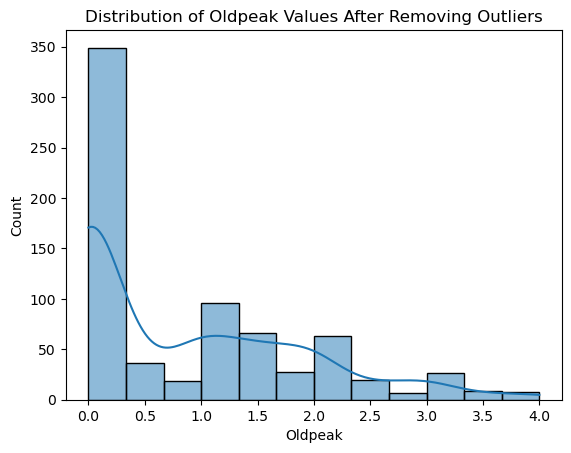

In [27]:
# Visualizing the distribution after removing outliers
sb.histplot(df_old['Oldpeak'], kde=True)
plt.title('Distribution of Oldpeak Values After Removing Outliers')
plt.show();

In [28]:
df1 = df_old.drop(columns=['RestingBP_zscore'], axis = 1)
df1[:2]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Cholesterol_zscore
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,8.458582
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,2.571194


### One Hot Encoding

In [29]:
label_e = LabelEncoder()

In [30]:
# list of columns with categorical values
cat_columns = [col for col in df1.select_dtypes(include='object').columns]
cat_columns   

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [31]:
# each column in object_col will be iterated to apply the label encoder
for col in cat_columns:
    df1[col] = label_e.fit_transform(df1[col])

In [32]:
df1[:2]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Cholesterol_zscore
0,40,1,1,140,289,0,1,172,0,0.0,2,0,8.458582
1,49,0,2,160,180,0,1,156,0,1.0,1,1,2.571194


In [33]:
# copying df1 dataframe to df2
df2 = df1.copy()
df2[:2]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Cholesterol_zscore
0,40,1,1,140,289,0,1,172,0,0.0,2,0,8.458582
1,49,0,2,160,180,0,1,156,0,1.0,1,1,2.571194


In [34]:
# The X variables will be selected and converted to series
X = df2.drop(columns =['HeartDisease'], axis = 1).values

# Selecting the target variable
y = df2['HeartDisease']

In [35]:
# Getting the indices of the categorical columns
cat_indices = [df2.columns.get_loc(col) for col in cat_columns]
cat_indices

[1, 2, 6, 8, 10]

In [36]:
col_transformer = ColumnTransformer(transformers = [
    ('cat', OneHotEncoder(), cat_indices)
],remainder = 'passthrough')

In [37]:
X_trans = col_transformer.fit_transform(X)

In [38]:
X_trans.shape

(726, 21)

#### Scaling the Features

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_trans)
X_scaled

array([[-0.56992764,  0.56992764, -0.98360545, ...,  1.29110344,
        -0.86173699,  0.90680518],
       [ 1.7546087 , -1.7546087 , -0.98360545, ...,  0.6382737 ,
         0.13052479, -1.18109732],
       [-0.56992764,  0.56992764, -0.98360545, ..., -1.7282341 ,
        -0.86173699,  0.79187476],
       ...,
       [-0.56992764,  0.56992764,  1.01666781, ..., -1.0346025 ,
         0.32897715, -2.11969568],
       [ 1.7546087 , -1.7546087 , -0.98360545, ...,  1.37270716,
        -0.86173699, -0.10841347],
       [-0.56992764,  0.56992764, -0.98360545, ...,  1.3319053 ,
        -0.86173699, -1.27687266]])

In [40]:
# Splitting the dataset nto train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 0)

In [41]:
# Building model and slection of parameters
model_params = {
        'svm': {
        'model': SVC(gamma = 'scale'),
        'params': {
            'C': [1, 5, 10, 15, 20],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
    'params': {
        'n_estimators': [1, 5, 10, 15, 20]
    }
    },
    
    'logistic_regression': {
        'model': LogisticRegression(solver = 'liblinear', multi_class = 'auto'),
        'params': {
            'C': [1, 5, 10, 15, 20],
            'penalty': ['l1', 'l2']
        }
    },
    'Decision_Tree': {
        'model': DecisionTreeClassifier(),
    'params': {
        'criterion': ["gini", "entropy", "log_loss"]
    }
}
    
}

In [42]:
scores = []
for model_name, model_para in model_params.items():
    clf = GridSearchCV(model_para['model'], model_para['params'], return_train_score = False, cv = 5)
    clf.fit(X_train, y_train)

    # Predicting the test set
    y_pred = clf.predict(X_test)

    # Storing the results
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [43]:
# Putting the score values in a dataframe
df_score = pd.DataFrame(scores)
df_score

,model,best_score,best_params
0,svm,0.887931,"{'C': 1, 'kernel': 'rbf'}"
1,random_forest,0.884483,{'n_estimators': 20}
2,logistic_regression,0.875862,"{'C': 1, 'penalty': 'l1'}"
3,Decision_Tree,0.815517,{'criterion': 'gini'}


## PCA

In [44]:
pca = PCA(0.95)  # This will make PCA to provide calculated output of 95% needed columns or features among the features

In [45]:
X_pca = pca.fit_transform(X_trans)
X_pca.shape

(726, 3)

In [46]:
pca.explained_variance_ratio_  # This is to see the percent of component captured per column

array([0.73999316, 0.16961749, 0.07085588])

In [47]:
pca.n_components_  # Number of columns

3

In [48]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y, test_size = 0.2, random_state = 0)

In [49]:
# Building model and slection of parameters
model_params2 = {
        'svm': {
        'model': SVC(gamma = 'scale'),
        'params': {
            'C': [1, 5, 10, 15, 20],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
    'params': {
        'n_estimators': [1, 5, 10, 15, 20]
    }
    },
    
    'logistic_regression': {
        'model': LogisticRegression(solver = 'liblinear', multi_class = 'auto'),
        'params': {
            'C': [1, 5, 10, 15, 20],
            'penalty': ['l1', 'l2']
        }
    },
    'Decision_Tree': {
        'model': DecisionTreeClassifier(),
    'params': {
        'criterion': ["gini", "entropy", "log_loss"]
    }
}
    
}

In [50]:
scores2 = []
for model_name, model_para in model_params2.items():
    clf = GridSearchCV(model_para['model'], model_para['params'], return_train_score = False, cv = 5)
    clf.fit(X_train2, y_train2)

    # Predicting the test set
    y_pred = clf.predict(X_test2)

    # Storing the results
    scores2.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [51]:
# Putting the score values in a dataframe
df_score2 = pd.DataFrame(scores2)
df_score2

,model,best_score,best_params
0,svm,0.693103,"{'C': 1, 'kernel': 'linear'}"
1,random_forest,0.651724,{'n_estimators': 15}
2,logistic_regression,0.691379,"{'C': 1, 'penalty': 'l1'}"
3,Decision_Tree,0.618966,{'criterion': 'entropy'}


## PCA with Components Stated

In [52]:
pca2 = PCA(n_components=5)  # Changing the components or columns to 6 instead of 95% 
X_pca2 = pca2.fit_transform(X_trans)
X_pca2.shape

(726, 5)

In [53]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_pca, y, test_size = 0.2, random_state = 0)

In [54]:
# Building model and slection of parameters
model_params3 = {
        'svm': {
        'model': SVC(gamma = 'scale'),
        'params': {
            'C': [1, 5, 10, 15, 20],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
    'params': {
        'n_estimators': [1, 5, 10, 15, 20]
    }
    },
    
    'logistic_regression': {
        'model': LogisticRegression(solver = 'liblinear', multi_class = 'auto'),
        'params': {
            'C': [1, 5, 10, 15, 20],
            'penalty': ['l1', 'l2']
        }
    },
    'Decision_Tree': {
        'model': DecisionTreeClassifier(),
    'params': {
        'criterion': ["gini", "entropy", "log_loss"]
    }
}
    
}

In [55]:
scores4 = []
for model_name, model_para in model_params3.items():
    clf = GridSearchCV(model_para['model'], model_para['params'], return_train_score = False, cv = 5)
    clf.fit(X_train3, y_train3)

    # Predicting the test set
    y_pred = clf.predict(X_test3)

    # Storing the results
    scores4.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [57]:
# Putting the score values in a dataframe
df_score3 = pd.DataFrame(scores4)
df_score3

,model,best_score,best_params
0,svm,0.693103,"{'C': 1, 'kernel': 'linear'}"
1,random_forest,0.656897,{'n_estimators': 20}
2,logistic_regression,0.691379,"{'C': 1, 'penalty': 'l1'}"
3,Decision_Tree,0.610345,{'criterion': 'log_loss'}


In [58]:
# Selecting the best model to save
best_model = None
best_score = 0

for model_name, model_par in model_params3.items():
    clf = GridSearchCV(model_par['model'], model_par['params'], return_train_score = False, cv = 5)
    clf.fit(X_train3, y_train3)

    # Predicting on the test set
    y_pred = clf.predict(X_test3)

    # Storing the results
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Trackng the best model across all iterations
    if clf.best_score_ > best_score:
        best_score = clf.best_score_
        best_model = clf.best_estimator_

print(f'The best model overall is: {best_model}')

The best model overall is: SVC(C=1, kernel='linear')


## Confusion Matrix

In [59]:
# Calculating confusion matrix for the best model

best_model = best_model.fit(X_train3, y_train3)
y_pred_best = best_model.predict(X_test3)

cm = confusion_matrix(y_test3, y_pred_best)
cm

array([[55, 17],
       [34, 40]], dtype=int64)

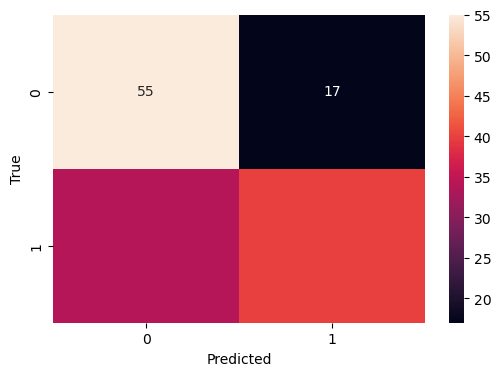

In [60]:
# Visualizing the confusion matrix
plt.figure(figsize =[6, 4])
sb.heatmap(cm, annot = True)
plt.xlabel("Predicted")
plt.ylabel('True');

### Saving the best model

In [61]:
# Saving the model as a pickle file
with open('model_heart_PCA.pkl', 'wb') as f:
    pk.dump(best_model, f)